# RoBERTa - fine-tuned transformer overview

## ✅🔁 Load model and tokenizer

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_path = "../models/roberta_louisck"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


## ✅🧾 Load validation data

In [2]:
val_df = pd.read_csv("../data/louis_ck_val_auto_labeled.csv")

# Map text labels to integers (in case you didn’t before)
label_map = {"non_irony": 0, "irony": 1}
val_df["label"] = val_df["irony_sarcasm_label"].str.lower().str.strip().map(label_map).astype(int)


## ✅🧠 Tokenize validation set and predict

In [3]:
# Tokenize the validation text
encodings = tokenizer(
    val_df["context_window"].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    y_pred = torch.argmax(logits, dim=1).numpy()

y_true = val_df["label"].to_numpy()


## ✅📊 Confusion Matrix

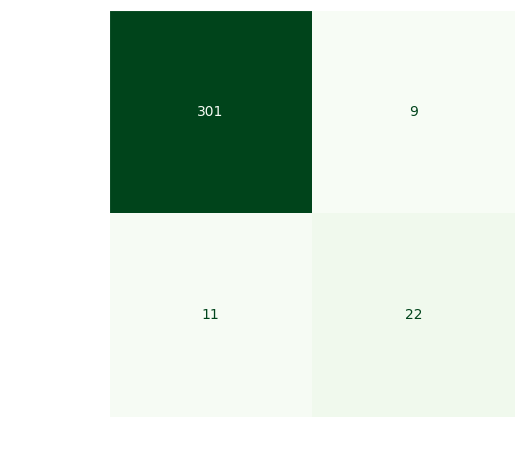

In [4]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non_irony", "Irony"])

fig, ax = plt.subplots()
disp.plot(ax=ax, cmap="Greens", colorbar=False)

# Make background transparent and all text white
fig.patch.set_alpha(0.0)              # Transparent background
ax.set_facecolor('none')              # Transparent axes
for label in (ax.get_xticklabels() + ax.get_yticklabels() + [ax.title, ax.xaxis.label, ax.yaxis.label]):
    label.set_color('white')          # White text
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(colors='white')        # White ticks
plt.grid(False)
plt.tight_layout()
plt.show()


## ✅🧮 Classification Report

In [5]:
print(classification_report(y_true, y_pred, target_names=["Non_irony", "Irony"]))

              precision    recall  f1-score   support

   Non_irony       0.96      0.97      0.97       310
       Irony       0.71      0.67      0.69        33

    accuracy                           0.94       343
   macro avg       0.84      0.82      0.83       343
weighted avg       0.94      0.94      0.94       343



C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_17900\1674007028.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_score = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()


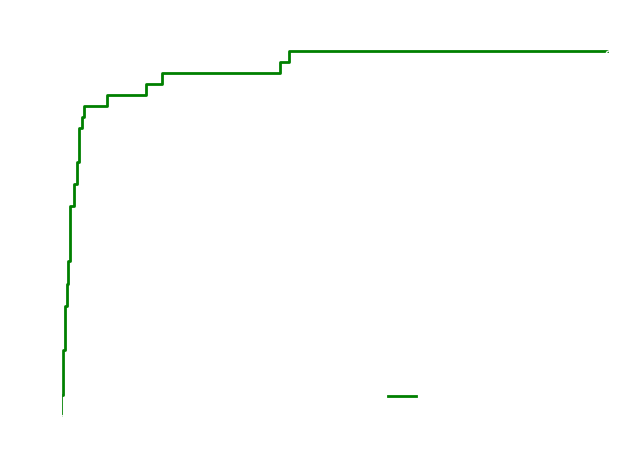

In [6]:
# y_score = softmax output for class 1 (irony)
y_score = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='white', linestyle='--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('ROC Curve', color='white')
plt.legend(loc="lower right", facecolor='none', edgecolor='white', labelcolor='white')

ax = plt.gca()
ax.set_facecolor('none')                   # Transparent axes
ax.tick_params(colors='white')            # White ticks
for spine in ax.spines.values():
    spine.set_edgecolor('white')          # White frame
plt.grid(False)
plt.tight_layout()
plt.show()


## ✅📊 Heatmap of Precision / Recall / F1

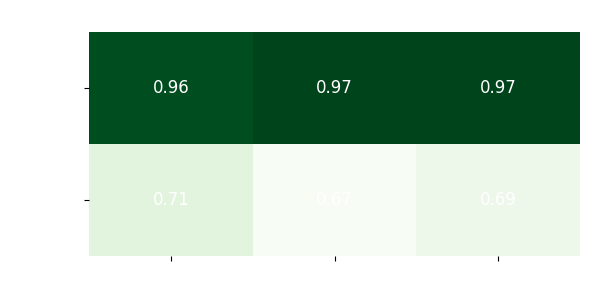

In [7]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get the report as a dict
report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=["Non_irony", "Irony"])

# Turn into a DataFrame (exclude 'accuracy', 'macro avg', etc. if you want)
report_df = pd.DataFrame(report_dict).transpose().round(2)
display_df = report_df.loc[["Non_irony", "Irony"], ["precision", "recall", "f1-score"]]

# Plot it
plt.figure(figsize=(6, 3))
sns.heatmap(display_df, annot=True, cmap="Greens", fmt=".2f", cbar=False,
            annot_kws={"color": "white", "size": 12})

plt.title("Classification Report", color="white")
plt.xticks(color='white')
plt.yticks(color='white', rotation=0)
plt.gca().set_facecolor('none')
plt.tight_layout()
plt.savefig("../plots/classification_report_heatmap.png", transparent=True, dpi=300)
plt.show()
